# Heart Disease Classification
15-388: Practical Data Science Final Project, by Abhiram Gogate (angogate) and Gaurav Chatterjee (gchatter)

## Introduction

### Heart Disease
Heart disease is the leading cause of death in the United States - in 2014, the CDC reports that 614,348 people died as a result of heart disease, which is almost 20,000 above cancer, and almost 400,000 higher than the next leading cause of death, chronic lower respiratory diseases. link: http://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm. As a result, there is increased awareness about heart disease and prevention - fundraisers such as Jump Rope for Heart are increasingly popular in the United States. Stopping heart disease is thus an extremely important problem in medical science today. 

Through studies, it is commonly known that there are various indicators that lead to heart disease - some of these include smoking, family history, and BMI (body mass index). link: https://www.goredforwomen.org/know-your-risk/find-out-your-risk/know-your-risk-for-cardiovascular-disease/. The goal of this project is to use a data-driven approach to answer which set of indicators can best predict the presence of heart disease in a potential patient. There are currently many, many signs of heart disease out there - this project will attempt to figure out which ones correlate most with the presence of heart disease by using various data science techniques.

### Methodologies
This report will go through the following steps to, hopefully, reach the goal of determining the most important features to use in prediction. 

1. Data Gathering + Cleaning Data
2. Visualization!
3. Initial Predictions
4. Cross Validation
5. Feature Selection with Recursive Feature Elimination (RFE)
6. Conclusion


In [1]:
import pandas as pd
import numpy as np
from StringIO import StringIO
import sys

import matplotlib
matplotlib.use("svg")
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("ggplot")

## Data Gathering + Cleaning Data

### Data Gathering
The first step was to find data related to heart disease and the list of features that are commonly thrown out there as indicators for heart disease (as described above). This data will then be used to construct a model (SVM, random forest, or gradient descent by using a optimal number of features) for prediction of heart disease. After researching, a study uploaded by David Aha of the Naval Research Laboratory had raw data containing exactly what was needed for the report. An example of a data dump is found here: http://mlearn.ics.uci.edu/databases/heart-disease/cleveland.data. It is clear that the data is not pre-processed in any form, and is the result of raw data taken from the Cleveland Clinic (in, of course, Cleveland, Ohio). There are three other data dumps found on this website, which have data from hospitals in Budapest, Long Beach, and Zurich.

The processed data available on the website was not used, as their team determined their own subset of features, and used those instead. Since the goal of the project is to determine the optimal set of features, the processed data was not considered for this report.

The datasets themselves have 57 different features, all of which were taken (for the most part) whenever a patient would enter the hospital. The last few variables are the labels, the most important of which is "num", which is 0 on a negative diagnosis, and > 0 on a positive one. The dataset was not formatted though, and all the features and labels were seperated by either spaces or whitespace. So, first, a significant amount of data cleaning had to be done.


### Cleaning Data 
In this report, we have only considered the unprocessed Cleveland data set - ideally, these methedologies can be applied to any combination of data sets in a similar unprocessed format. 

The key was to note that the string "name" meant the start of a new data point - all data points ended with the name of the patient, which was set to the string "name" for privacy concerns.

After doing this, the data was loaded in to a dataframe, and the columns were manually went through to determine overall usefulness to our project - this entailed removing columns that had a lot of null's in them, and removing features such as cardiac catheterization date, which would clearly not help us predict the presence of heart disease. The names and explanations of the features can be found here: http://mlearn.ics.uci.edu/databases/heart-disease/heart-disease.names. 


In [40]:
def read_data_file(fname):
    '''parses data in .data format'''
    with open(fname, "rt") as fread:
        contents = fread.read()
        data = ""
        for c in contents.splitlines():
            if(c.startswith("299") and fname == "cleveland.data"): #corrupted data begins with patient 299
                break
            data += c
            data += " "
    data = data.replace("name", ",")
    data = data.replace(" , ", ",")
    # taken from: http://stackoverflow.com/questions/22604564/how-to-create-a-pandas-dataframe-from-string
    stringio = StringIO(data)
    res = pd.read_csv(stringio, sep=" ", lineterminator=",", header=None)
    return res
    
def join_data_files(*args):
    '''returns a pandas dataframe with data from multiple .data files with the same columns'''
    L = []
    for i in xrange(len(args)):
        L.append(read_data_file(args[i]))
    return pd.concat(L)

df = join_data_files("cleveland.data") # other data sets did not have enough features
df = df.dropna().reset_index(drop = True) # drop NaNs and reset the index

df = df.drop([0,1,7] + range(19,30) + [35] + range(39,43)+ [44,45] + range(51,57) + range(58,75), axis = 1)
# these are the columns we determined to be useless or irrelevant

df = df.replace(-9, np.nan) # our data source represented missing information with -9
df.columns = ["age", "sex", "painloc", "painexer", "relrest", "cp", "trestbps", "htn", "chol", "smoke", "cigs",
              "years", "fbs", "dm", "famhist", "restecg", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd",
              "trestbpd", "exang", "xhypo", "ca", "restef", "restwm", "exeref", "exerwm", "thal", "num"]
for col in df.columns:
    if df[col].isnull().sum() < 20: # if there are fewer than 20 NaNs in a column, we'll drop those rows (http://stackoverflow.com/questions/26266362/how-to-count-the-nan-values-in-the-column-in-panda-data-frame)
        df = df.dropna(axis=0, subset=[col])
df = df.dropna(axis=1) # we'll drop columns that have greater than 20 NaNs
print df.head()

   age  sex  cp  trestbps  htn  chol  cigs  years  fbs  famhist ...   thalach  \
0   63    1   1       145    1   233  50.0   20.0    1        1 ...       150   
1   67    1   4       160    1   286  40.0   40.0    0        1 ...       108   
2   67    1   4       120    1   229  20.0   35.0    0        1 ...       129   
3   37    1   3       130    0   250   0.0    0.0    0        1 ...       187   
4   41    0   2       130    1   204   0.0    0.0    0        1 ...       172   

   thalrest  tpeakbps  tpeakbpd  trestbpd  exang  xhypo   ca  thal  num  
0        60       190        90        85      0      0  0.0   6.0    0  
1        64       160        90        90      1      0  3.0   3.0    2  
2        78       140        80        80      1      0  2.0   7.0    1  
3        84       195        68        78      0      0  0.0   3.0    0  
4        71       160        74        86      0      0  0.0   3.0    0  

[5 rows x 22 columns]


## Visualizations

Now that the initial data curating and processing has been done, the data will now be visualized.

### Histograms
The clearest visualization in the case of this data set is histograms and bar graphs. This was done to effectively visualize whether or not each individual feature has a distinct effect on the outcome of the diagnosis. For example, one trend that was expected to be seen (but not eventually found) was that patients over the age of 50 were more likely to receive a yes diagnosis rather than a no. By our visualizations, such trends can easily be spotted.

An important note: the num variable in the unprocessed data, as mentioned before has the value 0 if no heart disease is present, and 1,2,3,4 otherwise. Since the focus solely on classification, a new variable called num_presence was created, which is a boolean representing presence of heart disease.

After this, a histogram was created for each combination of features, and positive or negative diagnoses. The plots are shown below.


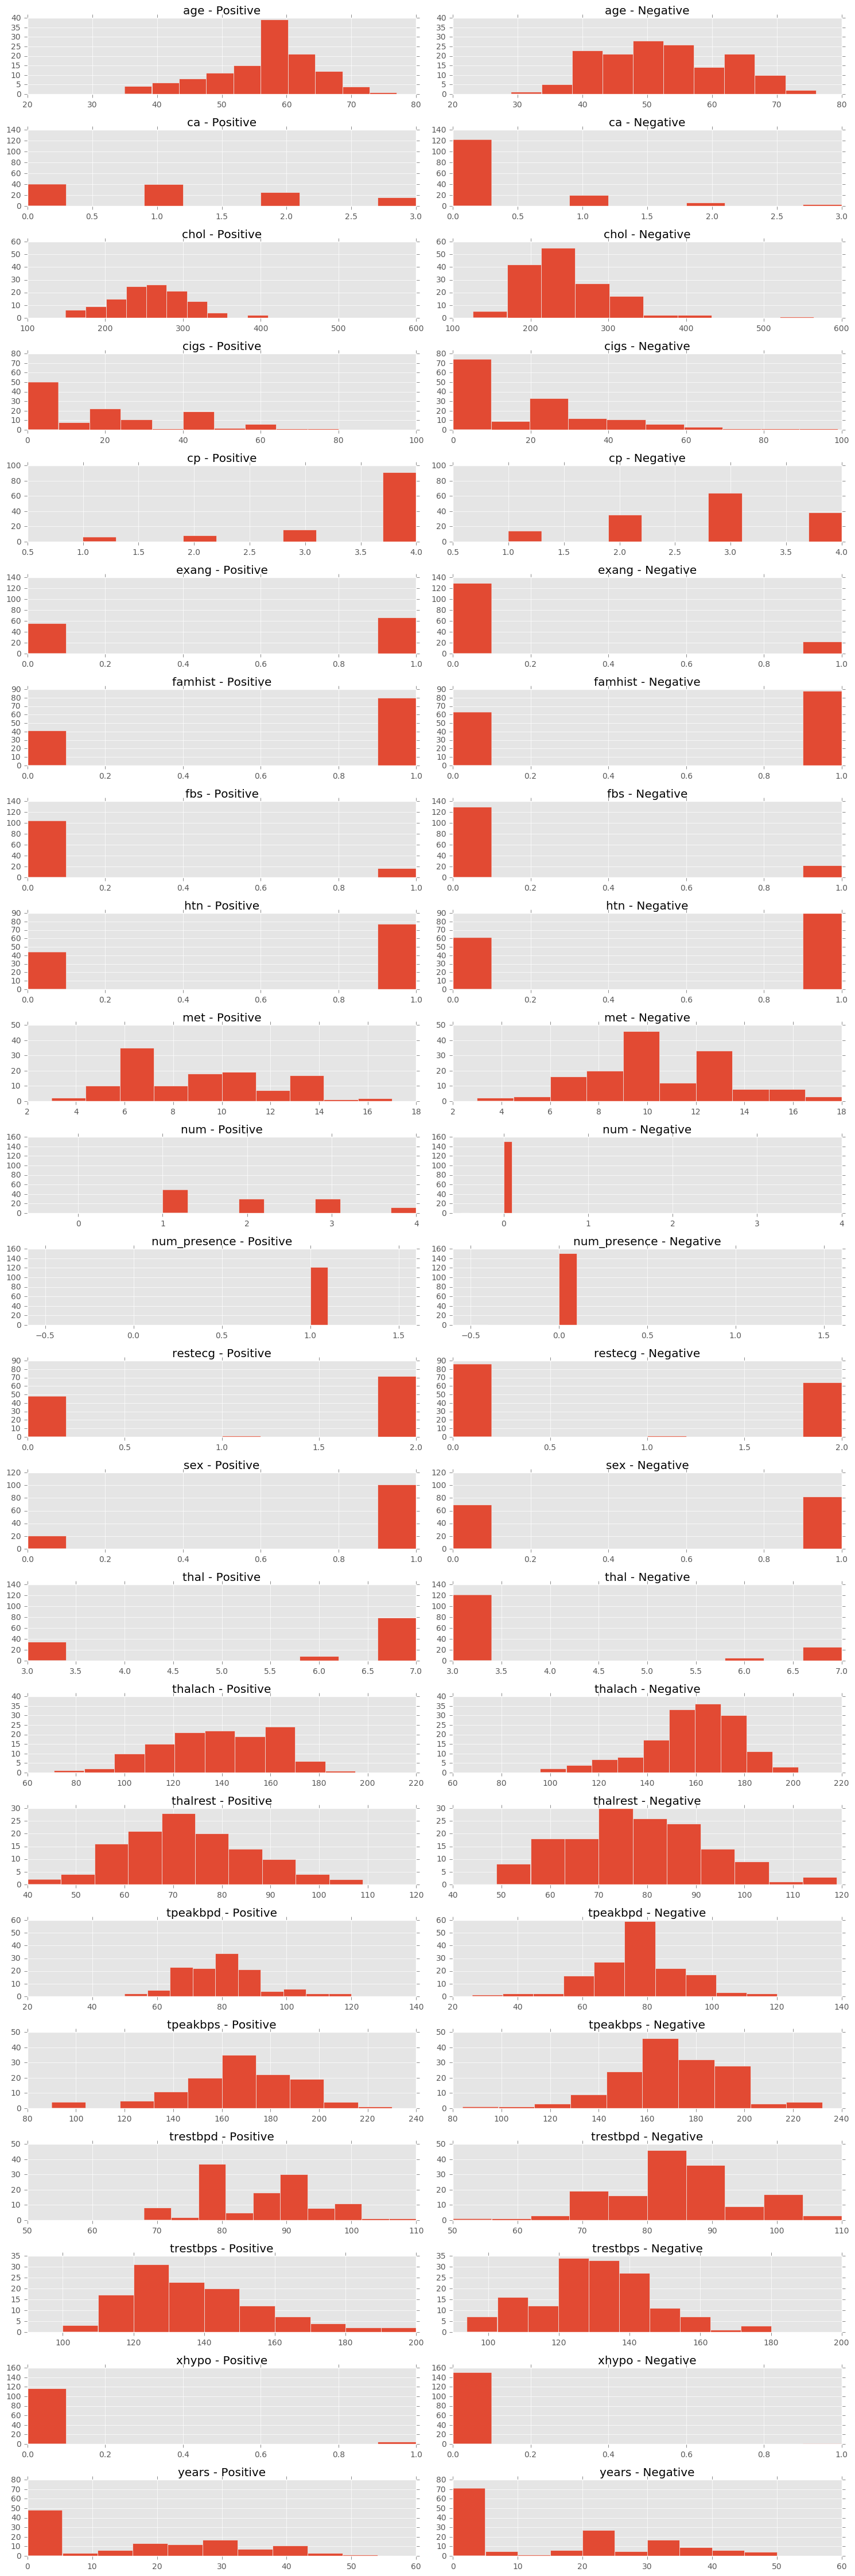

In [41]:
df["num_presence"] = df["num"] != 0 # binary variable: 1 if heart disease, 0 if no heart disease
dict_df = {name:group for name, group in df.groupby(df["num_presence"])}
positives = dict_df[True]  # only patients with heart disease
negatives = dict_df[False] # only patients without heart disease

# used http://matplotlib.org/api/pyplot_api.html for function names
_, plots = plt.subplots(len(positives.columns),2,figsize=(15,45))
for i in xrange(len(positives.columns)):
    col = sorted(positives.columns)[i]
    plots[i,0].hist(positives[col])
    plots[i,0].set_title("%s - Positive"%col)
    lims0 = plots[i,0].get_xlim() + plots[i,0].get_ylim()
    plots[i,1].hist(negatives[col])
    plots[i,1].set_title("%s - Negative"%col)
    lims1 = plots[i,1].get_xlim() + plots[i,1].get_ylim()
    lims = [min([lims0[0], lims1[0]]), max([lims0[1], lims1[1]]), min([lims0[2], lims1[2]]), max([lims0[3], lims1[3]]),]
    # set axes on both plots to largest it needs to be
    plots[i,0].axis(lims)
    plots[i,1].axis(lims)

plt.tight_layout()

As you can see, the data for indicators such as age follow something similar to a normal distribution, with the maximum number of positive cases topping out at around 55-60. The biggest problem with this data is that it is hard to draw conclusions from it, simply because for quite a few features, it is hard, or nearly impossible to detect a trend in the data. Additionally, a major problem with this type of visualization, while useful for super quick detection of trends, is that it is biased towards characteristics of the general population. For example, it appears that patients aged 50-60 have the most risk of heart disease - however, this could possibly just be because there are many more 50-60 year olds than any other age group.

To rectify this problem, bar graphs were made which plotted the ratio of positive cases to total cases for each data point in a feature. This aims to minimize the effect that is described above.

#### Percentage of Heart Disease Patients with Each Characteristic

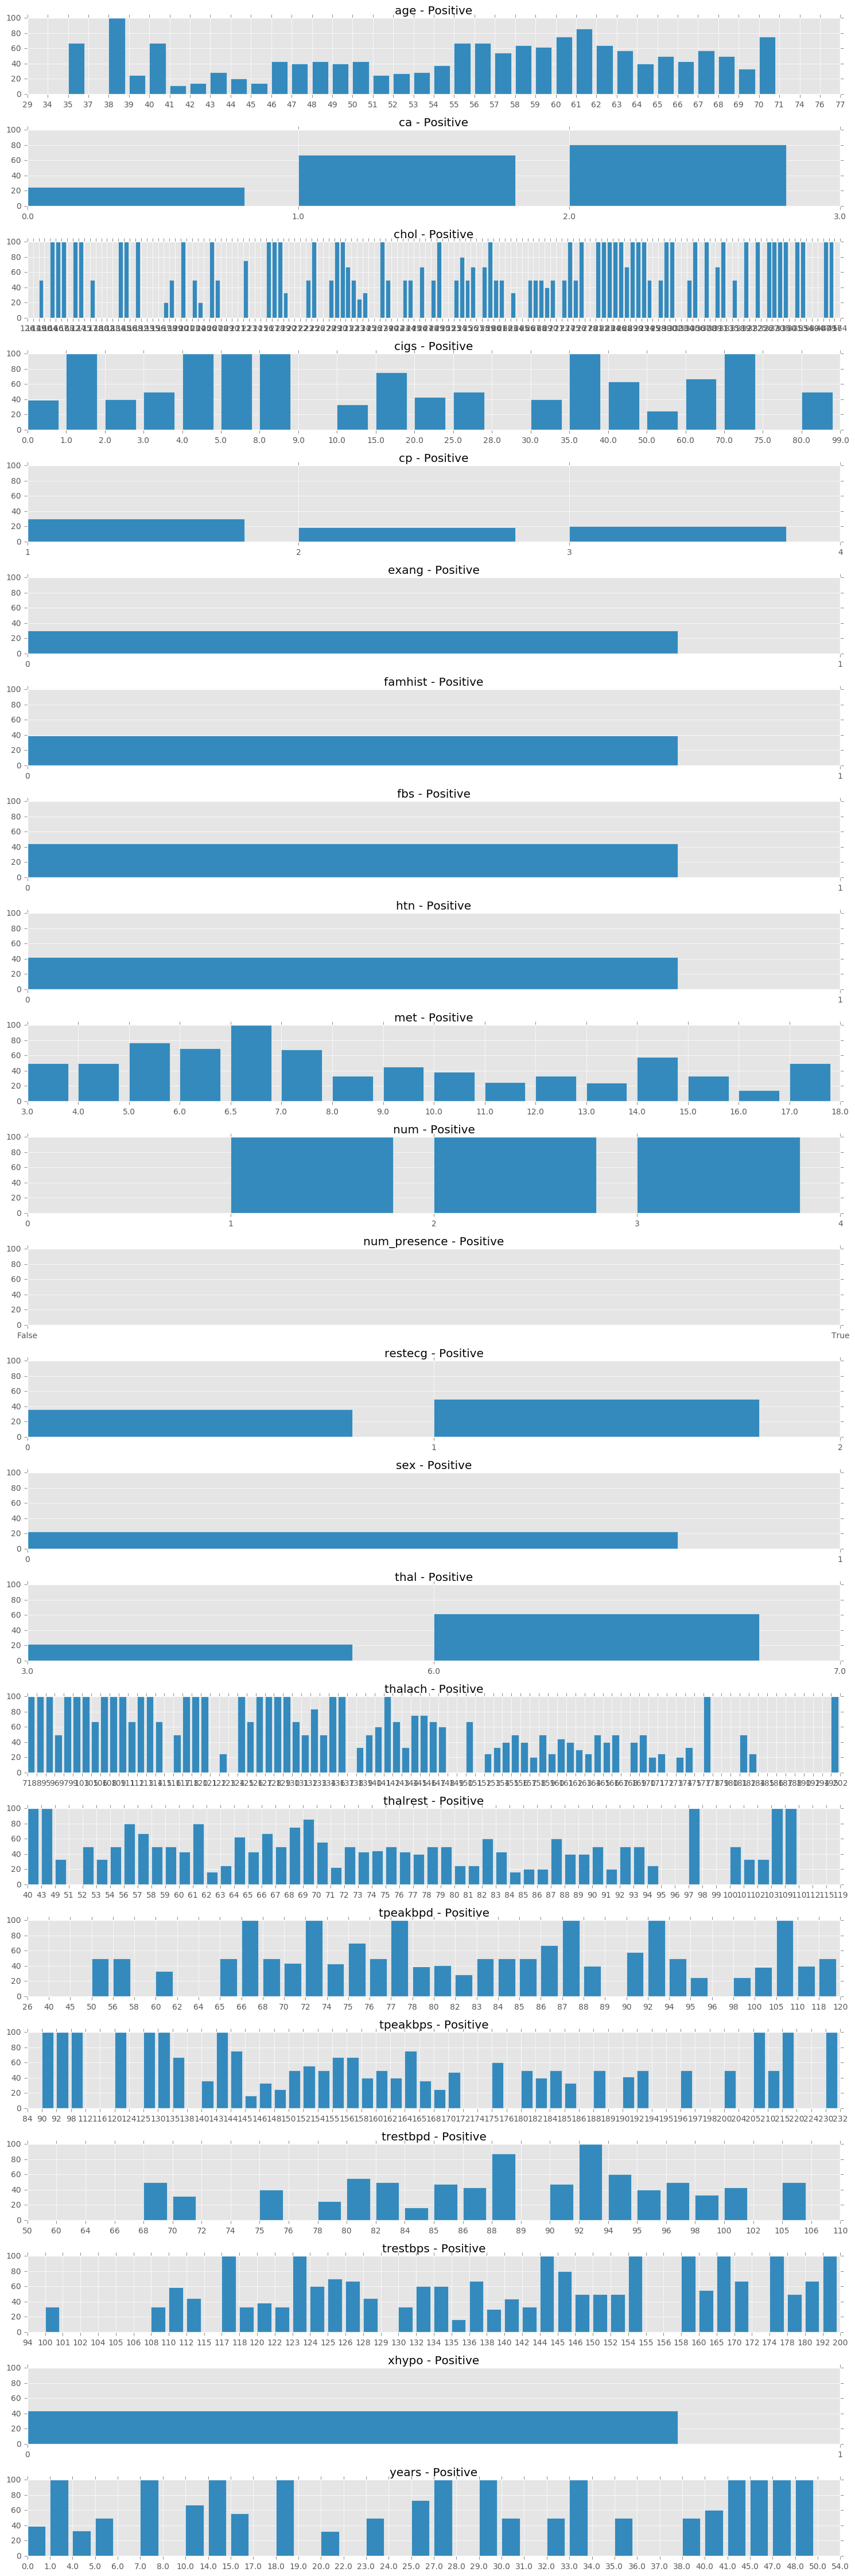

In [34]:
from collections import Counter

frames = {}
for col in positives.columns:
    # find ratios
    totcounter = Counter(df[col])
    totcounts  = np.array([totcounter[ct] for ct in sorted(totcounter)])
    poscounter = Counter(positives[col])
    for key in totcounter:
        if key not in poscounter:
            poscounter[key] = 0
    poscounts  = np.array([poscounter[ct] for ct in sorted(poscounter)])
    frames[col] = (sorted(totcounter), 100*poscounts/totcounts.astype(float))
    
_, plots = plt.subplots(len(frames),1,figsize=(15,45))

# for col in frames:
for i in xrange(len(frames)):
    col = sorted(frames)[i]
    plots[i].axis([None, None, 0, 100])
    plots[i].bar(range(len(frames[col][1])), frames[col][1], tick_label=frames[col][0])
    plots[i].set_title("%s - Positive"%col)

plt.tight_layout()

Its clear that there are certain variables that display an increasing trend. One example is age - while the bars themselves are not monotonically increasing, it is clear that the majority of the ages in the right half of the graph have higher ratios than the ages in the left half of the graph. Similarily, xhypo is an example of an indicator feature which displays higher ratios when it is 1. From an informal visual analysis, it can be concluded that 'age', 'sex', 'cp', 'chol', 'years', 'famhist', 'restecg', 'exang', 'xhypo', 'ca', and 'thal' all are strong indicators of heart disease presence. Of course, this is an extremely informal analysis - however, it helps to establish a general idea of which features can be considered important. Later on in the report, a formal analysis with Recursive Feature Elimination (RFE) will be done, and the results will compared to this informal analysis.

## Prediction
### Models Used
- Information about different models used.

In [70]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
import math

df_train = df.drop("num", axis=1).iloc[:197]
df_test  = df.drop("num", axis=1).iloc[197:]

for col in df_train.columns:
    df_train[col] = df_train[col].astype(float)
    df_test[col]  = df_test[col].astype(float)
    
epsilon = 1e-10

df_train_log = (df_train + epsilon).apply(np.log10)
X_train = df_train_log.drop("num_presence", axis=1)
y_train = df_train["num_presence"].astype(int)
df_test_log  = (df_test  + epsilon).apply(np.log10)
X_test = df_test_log.drop("num_presence", axis=1)
y_test = df_test["num_presence"].astype(int)

classifiers = [("Support Vector", SVC(probability=True)), ("Random Forest", RandomForestClassifier(n_estimators=500)),
               ("Gaussian Naive Bayes", GaussianNB()), ("Decision Tree", DecisionTreeClassifier()),
               ("Gradient Boosting", GradientBoostingClassifier())]

for name, clf in classifiers:
    clf.fit(X_train, y_train)
    print name
    print "predictions: ", clf.predict(X_test)
    print "score: ", clf.score(X_test, y_test)
    print

Support Vector
predictions:  [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 1
 1]
score:  0.573333333333

Random Forest
predictions:  [1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1
 0]
score:  0.8

Gaussian Naive Bayes
predictions:  [1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 0
 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1
 0]
score:  0.786666666667

Decision Tree
predictions:  [1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0
 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 0 0 0 1
 0]
score:  0.706666666667

Gradient Boosting
predictions:  [1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0
 0 0 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0 0 0

- Observations about classifiers
- Explanations why different classifiers performed the way they did

### Feature Engineering
#### Choosing Features
- How we chose features

In [72]:
dumb_features = ["trestbps", "htn", "cigs", "fbs", "met", "thalach", "thalrest", "tpeakbps", "tpeakbpd", "trestbpd"]
df_different = df.drop(dumb_features, axis=1)

df_train = df_different.drop("num", axis=1).iloc[:197]
df_test  = df_different.drop("num", axis=1).iloc[197:]

for col in df_train.columns:
    df_train[col] = df_train[col].astype(float)
    df_test[col]  = df_test[col].astype(float)
    
epsilon = 1e-10

df_train_log = (df_train + epsilon).apply(np.log10)
X_train = df_train_log.drop("num_presence", axis=1)
y_train = df_train["num_presence"].astype(int)
df_test_log  = (df_test  + epsilon).apply(np.log10)
X_test = df_test_log.drop("num_presence", axis=1)
y_test = df_test["num_presence"].astype(int)

classifiers_log = [("Support Vector", SVC(probability=True)), ("Random Forest", RandomForestClassifier(n_estimators=500)),
               ("Gaussian Naive Bayes", GaussianNB()), ("Decision Tree", DecisionTreeClassifier()),
               ("Gradient Boosting", GradientBoostingClassifier())]

for name, clf in classifiers_log:
    clf.fit(df_train_log.drop("num_presence", axis=1), df_train["num_presence"].astype(int))
    print name
    print "predictions: ", clf.predict(X_test)
    print "score: ", clf.score(X_test, y_test)
    print

 Support Vector
predictions:  [0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1
 0]
score:  0.626666666667

Random Forest
predictions:  [1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0]
score:  0.813333333333

Gaussian Naive Bayes
predictions:  [1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 1 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1
 0]
score:  0.826666666667

Decision Tree
predictions:  [1 1 1 0 0 0 0 0 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 1 0 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1
 1]
score:  0.733333333333

Gradient Boosting
predictions:  [1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0

- Observations about classifiers
- Explanations why different classifiers performed the way they did

## Cross Validation
"Assuming that some data is Independent Identically Distributed (i.i.d.) is making the assumption that all samples stem from the same generative process and that the generative process is assumed to have no memory of past generated samples." -sklearn documentation

In [73]:
from sklearn.model_selection import cross_val_predict, cross_val_score

df_log = (df + epsilon).apply(np.log10)
X = df_different.drop("num_presence", axis=1)
y = df_different["num_presence"].astype(int)

classifiers = [("Support Vector", SVC(probability=True)), ("Random Forest", RandomForestClassifier(n_estimators=500)),
               ("Gaussian Naive Bayes", GaussianNB()), ("Decision Tree", DecisionTreeClassifier()),
               ("Gradient Boosting", GradientBoostingClassifier())]
clf = RandomForestClassifier(n_estimators=500)
y_pred = cross_val_predict(clf, X, y)
y_score = cross_val_score(clf, X, y)
print y_pred
print y_score

[0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1
 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 1 1 1 1 0
 1 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 0 1
 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 0 0 0 0
 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 0 1 1 1 0
 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1
 0 1 1 0 0 1 1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 1
 0 1 0 1 0 1 0 0 0 1 0 1 0]
[ 1.  1.  1.]


In [77]:
# heavily adapted from: http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_digits.html
# and: http://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

svm_tuned_parameters = [{"kernel": ["rbf"], "gamma": [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
                        {"kernel": ["linear"], "C": [1, 10, 100, 1000]}]
rf_tuned_parameters  = [{"n_estimators": [1, 100, 500, 1000], "max_features": [0.5, 10, None, "sqrt", "log2"]}]
gnb_tuned_parameters = [{}]
dt_tuned_parameters  = [{"splitter": ["best", "random"], "max_features": [0.5, 10, None, "sqrt", "log2"]}]
gb_tuned_parameters  = [{"n_estimators": [1, 100, 500, 1000], learning}]

classifiers = [("Support Vector", SVC(probability=True), svm_tuned_parameter),
               ("Random Forest", RandomForestClassifier(n_estimators=500)),
               ("Gaussian Naive Bayes", GaussianNB()),
               ("Decision Tree", DecisionTreeClassifier()),
               ("Gradient Boosting", GradientBoostingClassifier())]

for clf for classifiers:
    tuned = GridSearchCV(clf[1], clf[2])
    tuned.fit(X_train, y_train)
    print clf[0], tuned.best_params_

{'kernel': 'linear', 'C': 10}


In [82]:
print clf.predict(X_test)
print clf.score(X_test, y_test)

[1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0
 0 0 0 0 1 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1
 0]
0.8
